**Boost Ideal CCM**

Dados los datos: 
- $F_{sw} = 40kHz$
- $V_d = 6V$
- $V_o = 15V$
- $\frac{\Delta V_o}{V_o} = 7\%$
- $V_{GG} = 18V$

Obtenemos:

In [3]:
import numpy as np

# Data
fsw = 40E3
Ts = 1/fsw
Vd = 6
Vo = 15
Vo_ripple = 0.07
Delta_Vo = Vo*Vo_ripple
VGG = 18

L = 220E-6
L_tol = 0.1
L_Q = 20
R_L = 2*np.pi*fsw*L/L_Q
ESR = 0.8

In [4]:
from utils import to_unit
from boost import *

# Definir una R de carga
R = 500
Io = Vo/R
print('Io = ' + to_unit(Io) + 'A')

# Calculamos D inicial
D = 1 - Vd/Vo

# Averiguamos si estamos en CCM o DCM
Iob = Vo*Ts*((1-D)**2)*D / (2*L)
print('Iob = ' + to_unit(Iob) + 'A')
print('')

if Io >= Iob:
    # Estamos en CCM
    print("Boost CCM")
    print(f'D = {D:.2g}')

    Ix = Io/(1-D)
    print('Ix = ' + to_unit(Ix) + 'A')
    
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    
    IL_max = Ix + Delta_Il/2
    print('IL_max = ' + to_unit(IL_max) + 'A')

    # Calculo Delta Q
    Delta_Q = CCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)

else:
    # Estamos en DCM
    print("Boost DCM")
    
    # Tiempos
    D = np.sqrt(( 2*L*Io / (Vd*Ts)) * (Vo/Vd - 1))
    Delta_1 = 2*L*Io / (Vd*D*Ts)
    print(f'D = {D:.2g}')
    print(f'Delta_1 = {Delta_1:.2g}')
    
    # Corrientes
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    IL_max = Delta_Il
    print('IL_max = ' + to_unit(IL_max) + 'A')
    
	# Calculo Delta Q
    Delta_Q = DCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)
    
Delta_Vc = Delta_Vo - Delta_Il*ESR
C = Delta_Q/Delta_Vc
print('C = ' + to_unit(C) + 'F')    
    
print('Po = ' + to_unit(Vo**2/R) + 'W')

Io = 30mA
Iob = 81.8mA

Boost DCM
D = 0.36
Delta_1 = 0.24
Delta_IL = 248mA
IL_max = 248mA
C = 680nF
Po = 450mW


# Gráficos

### Gráfico $I_L$

Io = 300mA


([<matplotlib.axis.XTick at 0x2c1b34f6d40>,
 [Text(0.0, 0, '0.0'), Text(2.5e-05, 0, '2.5')])

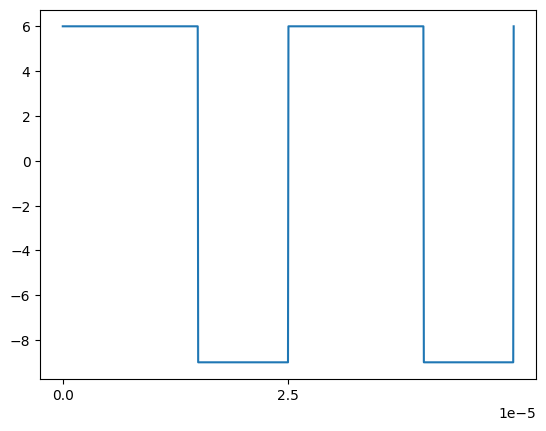

In [8]:
from utils import to_unit
from boost import *
import matplotlib.pyplot as plt

# Definir una R de carga
R = 1500
Io = Vo/R
print('Io = ' + to_unit(Io) + 'A')

t = np.linspace(0, 2*Ts, 1000)
IL = [get_IL(Vd, Vo, L, Ts, Io, ti) for ti in t]
VL = [get_VL(Vd, Vo, L, Ts, Io, ti) for ti in t]

plt.plot(t, VL)
plt.xticks([0, Ts])